# Load Dependencies

Loading required python packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#models
from sklearn.linear_model import LogisticRegression

# NLP Libraries
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from os import path
from PIL import Image
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import GridSearchCV, cross_val_score

#metrics, procssing and model selection
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
#Setting Plot figure size
sns.set(rc={'figure.figsize':(12.8,11.27)})

# Data Collection

As kaggle already provided us with data in the form of csv files, all we have to do is load them into dataframes.

In [2]:
#loading csv's
train=pd.read_csv('train.csv')
test=pd.read_csv('test_with_no_labels.csv')

In [3]:
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [4]:
train.shape

(15819, 3)

In [5]:
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \r\nPu...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [6]:
test.shape

(10546, 2)

# Data Cleaning

Kaggle tries to provide us with clean data but it's always a good idea to check for ourselves. We check for null and empty values.

In [7]:
train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [8]:
i=0
for x in train.columns:
    if '' in sorted(train[x].unique()):
        i+=1
print('The data contains '+str(i)+' empty values over all columns')

The data contains 0 empty values over all columns


none of our columns contain any null or empty values.

# Exploratory Data Analysis

In [9]:
train.describe()

,sentiment,tweetid
count,15819.000000,15819.000000
mean,0.917504,501719.433656
std,0.836537,289045.983132
min,-1.000000,6.000000
25%,1.000000,253207.500000
50%,1.000000,502291.000000
75%,1.000000,753769.000000
max,2.000000,999888.000000


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [11]:
#Evaluating the skewness
train.skew()

sentiment   -0.683959
tweetid     -0.008471
dtype: float64

In [12]:
#Evaluating the kurtosis
train.kurtosis()

sentiment    0.122976
tweetid     -1.193356
dtype: float64

## Distribution values  of labels

Text(0.5, 1.0, 'Distribution of sentiment labels')

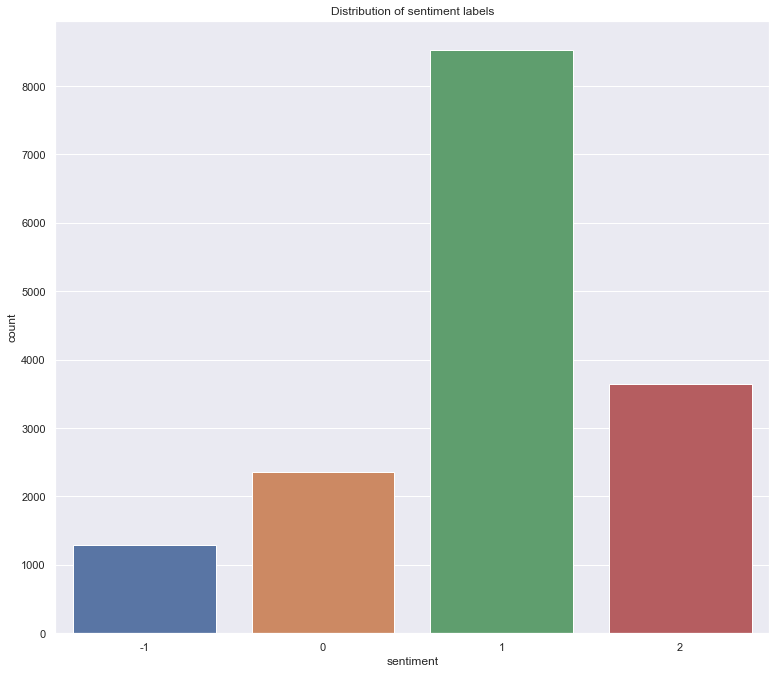

In [13]:
sns.countplot(x=train['sentiment'])
plt.title('Distribution of sentiment labels')

In [14]:
# checking the distribution
train['sentiment'].value_counts()/train.shape[0]

 1    0.539225
 2    0.230103
 0    0.148745
-1    0.081927
Name: sentiment, dtype: float64

## Number of Unique values:

In [15]:
train['sentiment'].unique()
train['sentiment'].value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

## Converting the Sentiment Labels from numbers to text

Changing the Sentiment numbers to legiable text for better transparancy on what they mean, so we can correlate and understand the data better

In [16]:
# Making a copy of the train data since we will be making changes to the dataset
train_df = train.copy()

In [17]:
train_df['sentiment'] = [['Negative', 'Neutral', 'Positive', 'News'][x+1] for x in train_df['sentiment']]

Text(0.5, 1.0, 'Message count per sentiment')

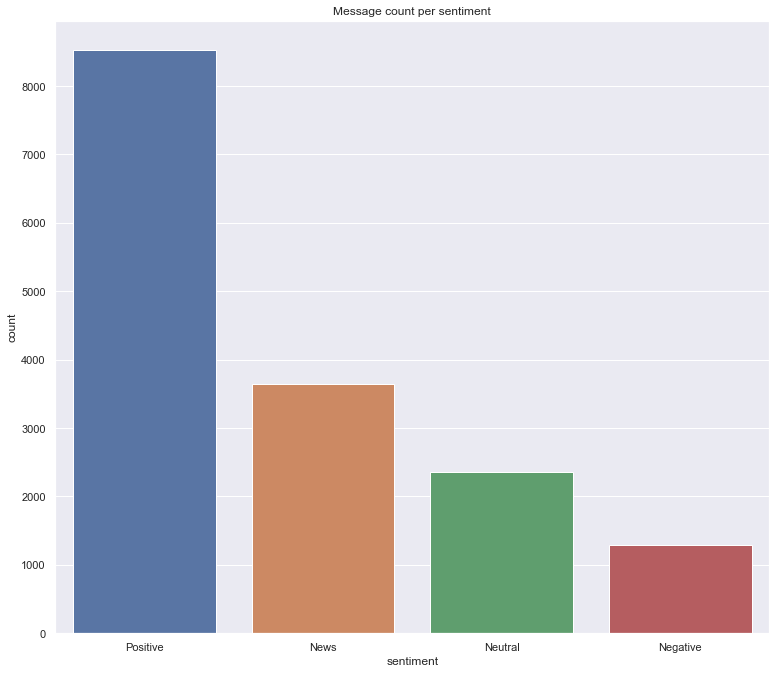

In [18]:
sns.countplot(x=train_df['sentiment'])
plt.title('Message count per sentiment')

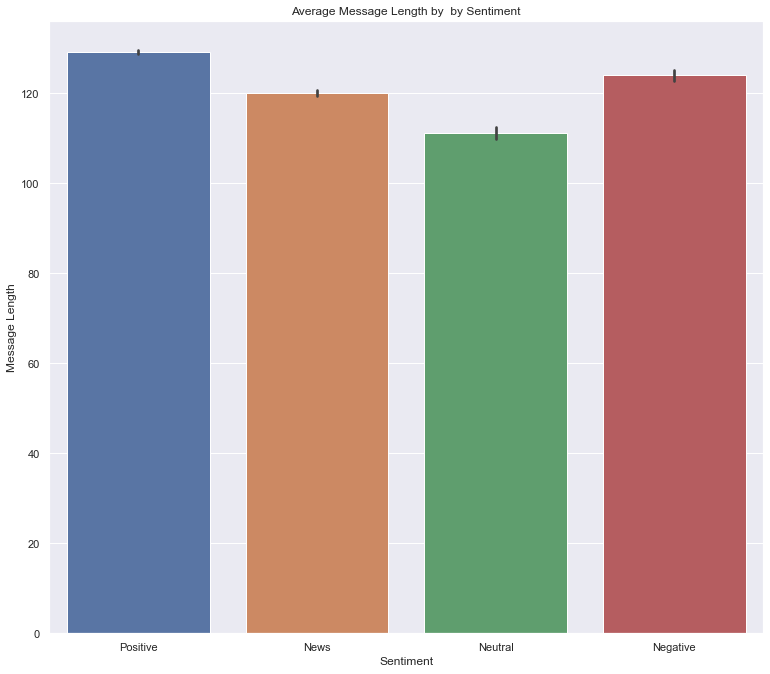

In [19]:
sns.barplot(x='sentiment', y=train_df['message'].apply(len) ,data = train_df)
plt.ylabel('Message Length')
plt.xlabel('Sentiment')
plt.title('Average Message Length by  by Sentiment')
plt.show()

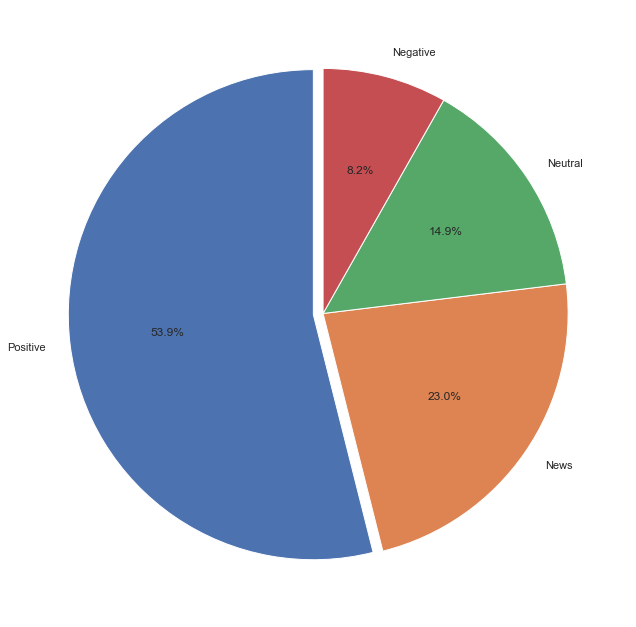

In [20]:
#numerical distribution
values = train_df['sentiment'].value_counts()/train_df.shape[0]
labels = (train_df['sentiment'].value_counts()/train_df.shape[0]).index
plt.pie(x=values, labels=labels, autopct='%1.1f%%', startangle=90, explode= (0.04, 0, 0, 0))
plt.show()

### Counting user names that are repeated in tweets

Here we are looking for Twitter accounts/users that are commonly brought up in messages

In [21]:
train_df['users'] = [''.join(re.findall(r'@\w{,}', line)) if '@' in line else np.nan for line in train_df.message]
counts = train_df[['message', 'users']].groupby('users', as_index=False).count().sort_values(by='message', ascending=False)

In [22]:
counts.head()

,users,message
3410,@StephenSchlegel,307
3270,@SenSanders,243
6182,@realDonaldTrump,143
448,@BernieSanders,121
612,@CNN,106


In [23]:
repeated_tags_rate = round(counts['message'][counts['message'] > 1].sum() * 100/len(counts['message']), 0)
print(f"{repeated_tags_rate} percent of the data are from repeated tags")

86.0 percent of the data are from repeated tags


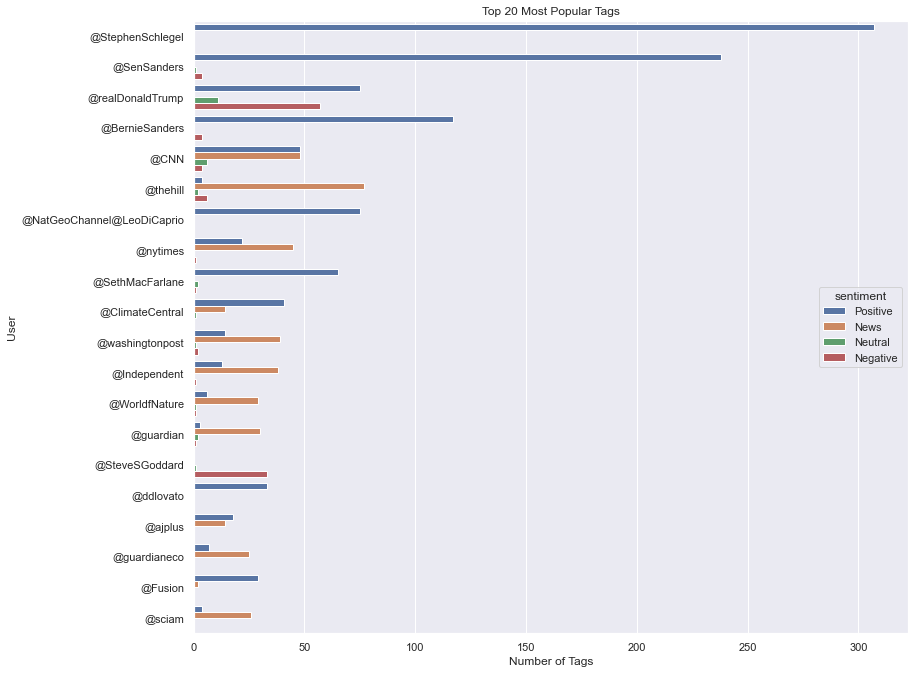

In [24]:
sns.countplot(y="users", hue="sentiment", data=train_df,
              order=train_df.users.value_counts().iloc[:20].index) 
plt.ylabel('User')
plt.xlabel('Number of Tags')
plt.title('Top 20 Most Popular Tags')
plt.show()

## Creating a Word Cloud

In [25]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = " ".join(tweet for tweet in train_df.message)
print ("There are {} words in the combination of all tweets.".format(len(text)))

There are 1976222 words in the combination of all tweets.


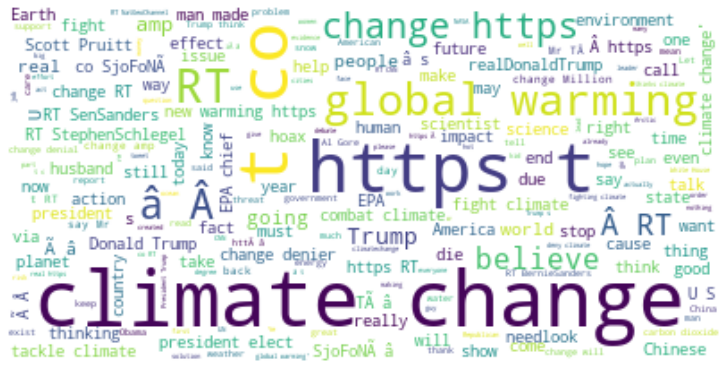

In [26]:
# Creating the wordcloud 
wordcloud = WordCloud(background_color="white").generate(text)

# Displaying the wordcloud:
# using matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Pre-processing

Make sure ntlk is properly downloaded and installed otherwise this code will not run!

In [27]:
import nltk
#nltk.download()

In [28]:
stop_words = set(stopwords.words('english'))
lemm = WordNetLemmatizer()
Tokenized_Doc=[]

In [29]:
for data in train_df['message']:
        review = re.sub('[^a-zA-Z]', ' ', data)
        url = re.compile(r'https?://\S+|www\.\S+')
        review = url.sub(r'',review)
        html=re.compile(r'<.*?>')
        review = html.sub(r'',review)
        emojis = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        review = emojis.sub(r'',review)
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(review)
        gen_tweets = [lemm.lemmatize(token) for token in tokens if not token in stop_words]
        Tokenized_Doc.append(gen_tweets)
        train_df['tokenized tweets'] = pd.Series(Tokenized_Doc)

In [30]:
train_df.shape

(15819, 5)

In [31]:
train_df.head()

,sentiment,message,tweetid,users,tokenized tweets
0,Positive,PolySciMajor EPA chief doesn't think carbon di...,625221,@mashable,"[PolySciMajor, EPA, chief, think, carbon, diox..."
1,Positive,It's not like we lack evidence of anthropogeni...,126103,NaN,"[It, like, lack, evidence, anthropogenic, glob..."
2,News,RT @RawStory: Researchers say we have three ye...,698562,@RawStory,"[RT, RawStory, Researchers, say, three, year, ..."
3,Positive,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,NaN,"[TodayinMaker, WIRED, pivotal, year, war, clim..."
4,Positive,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,@SoyNovioDeTodas,"[RT, SoyNovioDeTodas, It, racist, sexist, clim..."


<b>Analysising messages to determine which talk about climate change</b> (old section to be removed)

We can see there are a total of 15819 messages

In [32]:
df = pd.DataFrame(train_df['message'])
df.count()

message    15819
dtype: int64

We will now select all the rows which have following list of values climate and change in the message Column

In [33]:
search_values = ['climate','change']
df[df['message'].str.contains('|'.join(search_values ))].count()

message    12636
dtype: int64

Of those messages 12636 contain the words 'climate' and 'change' in them

In [34]:
df.loc[df['message'].str.contains("climate")].count()

message    12587
dtype: int64

Of those messages 12587 contain the word 'climate' in them

In [35]:
df.loc[df['message'].str.contains("change")].count()

message    12547
dtype: int64

Of those messages 12547 contain the word 'change' in them

In [36]:
df.loc[df['message'].str.contains("climate change")].count()

message    12471
dtype: int64

Of those messages 12471 contain the words 'climate change' in them

In [37]:
df[df['message'].str.contains("climate|change")].count()

message    12636
dtype: int64

^^ just testing an alternaive way to search for key words

# Pre-Processing (old section to be remade into Normalization)

Splitting the data into features and labels

In [38]:
# labels
y = train['sentiment']

# features
X = train.drop('sentiment', axis=1)

In [39]:
# Transforming the Features
X_transformed = pd.get_dummies(X, drop_first=True)

In [40]:
#Standarise the data
standard_scaler = StandardScaler()
standard_scaler.fit_transform(X_transformed )

array([[ 0.42728658, -0.00795105, -0.00795105, ..., -0.00795105,
        -0.00795105, -0.00795105],
       [-1.29954515, -0.00795105, -0.00795105, ..., -0.00795105,
        -0.00795105, -0.00795105],
       [ 0.68102932, -0.00795105, -0.00795105, ..., -0.00795105,
        -0.00795105, -0.00795105],
       ...,
       [-0.40642373, -0.00795105, -0.00795105, ..., -0.00795105,
        -0.00795105, -0.00795105],
       [ 1.10024922, -0.00795105, -0.00795105, ..., -0.00795105,
        -0.00795105, -0.00795105],
       [ 1.05384338, -0.00795105, -0.00795105, ..., -0.00795105,
        -0.00795105, -0.00795105]])

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=50)

## Training

Using Logistical Regression

In [49]:
lr = LogisticRegression()

In [50]:
lr.fit(X_train, y_train)

LogisticRegression()

In [51]:
lr.intercept_[0]

-7.585534905708794e-12

In [52]:
coeff_df = pd.DataFrame(lr.coef_.T, X_transformed.columns)
coeff_df

,0,1,2,3
tweetid,-1.439056e-06,-4.059810e-07,1.560269e-06,2.847680e-07
message_ yea your nudes are nice but what are your views on climate change' i just choked why is this me 😂,-2.639825e-15,9.105447e-15,-3.425326e-15,-3.040296e-15
message_!! climate change should not be a partisan issue !!,-1.751204e-15,-2.363569e-15,7.119133e-15,-3.004361e-15
message_#24hwatchparty #SimonDonner Climate Scientist From UBC giving us the history of climate change https://t.co/lJvfLHw5s4,-7.222243e-16,-1.316970e-15,-7.616601e-15,9.655795e-15
"message_#3Novices : G-20 fails to agree on free trade and protectionism — climate change is missing, too https://t.co/azw6Gl68A4 The world's finan…",-1.839316e-15,-2.424703e-15,7.285704e-15,-3.021685e-15
...,...,...,...,...
message_�� Most Americans want 'aggressive' action on climate change: Reuters/Ipsos poll https://t.co/zV8j28UcFh https://t.co/414CgDAI1F,-1.149255e-15,-1.847002e-15,-6.215410e-15,9.211667e-15
"message_�� namikawas: weavemama: maybe gangster whales is what we need in order to fight climate change Whales,... https://t.co/Np8OJBY52v",-9.084878e-16,1.039082e-14,-6.935312e-15,-2.547021e-15
message_����will continue to lead in climate change &amp; working together with ���� https://t.co/rlFokndFMX,-1.127147e-15,-1.823899e-15,5.687803e-15,-2.736758e-15
message_📢 #ClimateChange \r\nPeople prepare to fight their governments on climate change https://t.co/rcJ9VoUL7T\r\n#KRTpro #News,-1.085673e-15,-1.779542e-15,-6.392369e-15,9.257584e-15


In [53]:
pred_lr = lr.predict(X_test)

Assessing Model Performance:

In [54]:
from sklearn.metrics import confusion_matrix

In [55]:
confusion_matrix(y_test, pred_lr)

array([[   0,    0,  254,    0],
       [   0,    0,  457,    0],
       [   0,    0, 1736,    0],
       [   0,    0,  717,    0]], dtype=int64)

In [56]:
from sklearn.metrics import classification_report

In [57]:
print('Classification Report')
print(classification_report(y_test, pred_lr, target_names=['-1: Negative','0: Neutral','1: Positive', '2: News']))

Classification Report


C:\Users\dineo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

-1: Negative       0.00      0.00      0.00       254
  0: Neutral       0.00      0.00      0.00       457
 1: Positive       0.55      1.00      0.71      1736
     2: News       0.00      0.00      0.00       717

    accuracy                           0.55      3164
   macro avg       0.14      0.25      0.18      3164
weighted avg       0.30      0.55      0.39      3164



C:\Users\dineo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dineo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Using Feature Subset Selection to improve the model

### Variance Threshold

In [58]:
# lm instance for var thresh
lm_vt = LogisticRegression()

In [59]:
# Import the var thresh model and choose a threshold
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.019)

# Transform (i.e.: run selection on) the training data
X_train_vt = selector.fit_transform(X_train)

In [60]:
X_train_vt.shape

(12655, 2)

In [61]:
# Fit model to the transformed data
lm_vt.fit(X_train_vt, y_train)

LogisticRegression()

In [62]:
# Now we'll need to remove the same features we did in the thresholding process
X_test_vt = selector.transform(X_test)

# Generate predictions from var thresh model
pred_lm_vt = lm_vt.predict(X_test_vt)

In [63]:
print('Var Thresh Model')
print(classification_report(y_test, pred_lm_vt, target_names=['Negative', 'Neutral','Positive','News']))


Var Thresh Model
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       254
     Neutral       0.00      0.00      0.00       457
    Positive       0.55      1.00      0.71      1736
        News       0.00      0.00      0.00       717

    accuracy                           0.55      3164
   macro avg       0.14      0.25      0.18      3164
weighted avg       0.30      0.55      0.39      3164



C:\Users\dineo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dineo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dineo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


No improvement in F1 Score

### Full Model

In [64]:
lm_full = LogisticRegression()

In [65]:
# No transformations necessary
lm_full.fit(X_train, y_train)

LogisticRegression()

In [66]:
# Generate predictions from full model
pred_lm_full = lm_full.predict(X_test)


In [67]:
print('Full Model')
print(classification_report(y_test, pred_lm_full, target_names=['Negative', 'Neutral','Positive','News']))


Full Model
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       254
     Neutral       0.00      0.00      0.00       457
    Positive       0.55      1.00      0.71      1736
        News       0.00      0.00      0.00       717

    accuracy                           0.55      3164
   macro avg       0.14      0.25      0.18      3164
weighted avg       0.30      0.55      0.39      3164



C:\Users\dineo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dineo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dineo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### K-Best

In [68]:
# lm instance for k-best
lm_kbest = LogisticRegression()

In [69]:
# Import the feature selector module
from sklearn import feature_selection
from sklearn.feature_selection import f_classif

# Set up selector, choosing score function and number of features to retain
selector_kbest = feature_selection.SelectKBest(score_func=f_classif, k=20)

# Transform (i.e.: run selection on) the training data
X_train_kbest = selector_kbest.fit_transform(X_train, y_train)



C:\Users\dineo\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [    6    11    13 ... 14219 14221 14223] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\dineo\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [70]:
X_train_kbest.shape

(12655, 20)

In [71]:
# Fit model to the transformed data
lm_kbest.fit(X_train_kbest, y_train)

LogisticRegression()

In [72]:
# Before generating predictions, we'll need to transform the test data the same way we did the train data
X_test_kbest = selector_kbest.transform(X_test)

# Generate predictions from var thresh model
pred_lm_kbest = lm_kbest.predict(X_test_kbest)

In [73]:
print('KBest Model')
print(classification_report(y_test, pred_lm_kbest, target_names=['Negative', 'Neutral','Positive','News']))


KBest Model
              precision    recall  f1-score   support

    Negative       1.00      0.05      0.10       254
     Neutral       1.00      0.02      0.05       457
    Positive       0.55      1.00      0.71      1736
        News       1.00      0.00      0.01       717

    accuracy                           0.56      3164
   macro avg       0.89      0.27      0.22      3164
weighted avg       0.75      0.56      0.41      3164



We observe a slight improvement in the F1-Score

### Decision Tree

In [74]:
from sklearn.datasets import load_iris


from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [75]:
tree = DecisionTreeClassifier(random_state=42)

In [76]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

#### Testing

Now let's predict the sentiments for our test set and examine the performance of our model using a confusion matix.

In [77]:
pred_tree = tree.predict(X_test)

I'm curious to see how many of each class we have in this test set. Let's print that off before we print out the confusion matrix.

In [78]:
y_test.value_counts()

 1    1736
 2     717
 0     457
-1     254
Name: sentiment, dtype: int64

In [84]:
labels = ['Negative', 'Neutral','Positive','News']

pd.DataFrame(data=confusion_matrix(y_test, y_pred), index=labels, columns=labels)


,Negative,Neutral,Positive,News
Negative,13,8,208,25
Neutral,1,32,380,44
Positive,8,42,1522,164
News,0,19,614,84


In [85]:
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral','Positive','News']))

              precision    recall  f1-score   support

    Negative       0.59      0.05      0.09       254
     Neutral       0.32      0.07      0.11       457
    Positive       0.56      0.88      0.68      1736
        News       0.26      0.12      0.16       717

    accuracy                           0.52      3164
   macro avg       0.43      0.28      0.26      3164
weighted avg       0.46      0.52      0.44      3164



### Tuning parameters to improve the model

## Random Forest

In [87]:
from sklearn.ensemble import RandomForestClassifier

### Training

In [89]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Testing

let's predict the sentiments for our test set and examine the performance of our model using a confusion matrix.



In [91]:
pred_forest = forest.predict(X_test)

In [92]:
labels = ['Negative', 'Neutral','Positive','News']

pd.DataFrame(data=confusion_matrix(y_test, pred_forest), index=labels, columns=labels)


,Negative,Neutral,Positive,News
Negative,13,0,241,0
Neutral,0,18,439,0
Positive,0,0,1736,0
News,0,0,704,13


Our model does extremely well! beside the Positive sentiment. Let's also take a look at the classification report for our predicted values.

In [93]:
print(classification_report(y_test, pred_forest, target_names=['Negative', 'Neutral','Positive','News']))

              precision    recall  f1-score   support

    Negative       1.00      0.05      0.10       254
     Neutral       1.00      0.04      0.08       457
    Positive       0.56      1.00      0.71      1736
        News       1.00      0.02      0.04       717

    accuracy                           0.56      3164
   macro avg       0.89      0.28      0.23      3164
weighted avg       0.76      0.56      0.42      3164



### Tuning parameters to improve the model